# **End to End Image based Plant disease QA (RAG, Langchain and OpenAI)**

This Colab notebook builds an end-to-end plant disease diagnosis and question-answering pipeline by:

* Web scrapper for extracting top 5 links using google API: [Colab Link](https://colab.research.google.com/drive/1zG_uQYFZY9JZ3pEqTCxE7GSv3pOO6FtP#scrollTo=rv5b5ZSqRkhK)

* Preparing an embeddings-based QA system over a simple “knowledge base” of plant-disease facts.

* Pre-trained & Fine-tuned YOLO model: [Colab Link](https://colab.research.google.com/drive/1DZB-L4II6bK_OW2aHbespsTiIL-LnPrS)

* Loading a pre-trained & Finetuned YOLO model to detect and crop diseased leaves and using it as a tool call.

* Defining LangChain tools (plant_disease_qa and plant_disease_detect_tool) and combining them in a single Gradio app.

* Launching an interactive Gradio interface where you can upload a photo of a leaf, automatically detect the disease, and ask follow-up questions in natural language.

In [1]:
!pip install -q gradio
!pip -q install langchain
!pip install -U langchain-community -q
!pip install --upgrade langchain openai chromadb -q
!pip install -q langchain-openai
!pip install -q langchain-chroma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.3/730.3 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 86.2 MB/s eta 0

In [2]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 83.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Imports**

In [35]:
import os
from google.colab import userdata
import ast
import gradio as gr
import pandas as pd
import openai
import io, base64
from PIL import Image
import requests
import json
from typing import List
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from IPython.display import Markdown, display, update_display
from openai import OpenAI
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.embeddings import HuggingFaceEmbeddings

import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np
from ultralytics import YOLO

In [4]:
!nvidia-smi

Thu Jun 12 17:24:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Mounting the google drive and setting the work directory**

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
new_directory = '/content/drive/MyDrive/Agriculture_folder'

# Change the current working directory
os.chdir(new_directory)

# Verify the change by printing the current working directory
HOME = os.getcwd()
print("Current working directory:", HOME)

Current working directory: /content/drive/MyDrive/Agriculture_folder


**Infering Plant Disease detector**


image 1/1 /content/drive/MyDrive/Agriculture_folder/img916_jpg.rf.4fec53c7e1192f69e7ad6acd02f0c858.jpg: 640x640 2 Apple rust leafs, 55.8ms
Speed: 16.2ms preprocess, 55.8ms inference, 378.0ms postprocess per image at shape (1, 3, 640, 640)


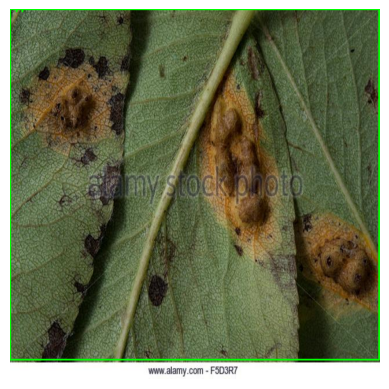

In [7]:
# All the model files are given in the github
#Infering and testing the plant disease detector

device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLO("best.pt")

img_path = "img916_jpg.rf.4fec53c7e1192f69e7ad6acd02f0c858.jpg"
image = cv2.imread(img_path)
if image is None:
    raise RuntimeError(f"Could not read image from path: {img_path}")

classNames = [
        'Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf',
        'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf',
        'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight',
        'Corn rust leaf', 'Peach leaf', 'Potato leaf',
        'Potato leaf early blight', 'Potato leaf late blight',
        'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf',
        'Strawberry leaf', 'Tomato Early blight leaf',
        'Tomato Septoria leaf spot', 'Tomato leaf',
        'Tomato leaf bacterial spot', 'Tomato leaf late blight',
        'Tomato leaf mosaic virus', 'Tomato leaf yellow virus',
        'Tomato mold leaf', 'Tomato two spotted spider mites leaf',
        'grape leaf', 'grape leaf black rot'
]

confidence_threshold = 0.5  # Adjust as desired

# Dictionary to store counts of each detected class
# detections_count = {}

# Run inference
results = model(img_path, device=device,imgsz=640)

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls_id = int(box.cls[0])
        conf   = float(box.conf[0])

        # Skip low-confidence detections
        if conf < confidence_threshold:
            continue

        # Convert class index to class name
        class_name = classNames[cls_id] if cls_id < len(classNames) else f"ID {cls_id}"

        # # Count the detection in the dictionary
        # if class_name not in detections_count:
        #     detections_count[class_name] = 0
        # detections_count[class_name] += 1

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Label with class name and confidence
        label = f"{class_name}: {conf:.2f}"
        cv2.putText(image, label, (x1, max(0, y1 - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

cv2.imwrite("output_image.jpg", image)

# Convert BGR -> RGB for matplotlib

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Use matplotlib to show image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

# **Preparing an embeddings-based QA system over a simple “knowledge base” of plant-disease facts.**

**Loading the Knowledge base**

In [8]:
# Initiating the Path
CSV_PATH = 'diseases_with_links.csv'
ROOT_DIR = 'Data'
KB_ROOT = "./Data/knowledge_base"

In [9]:
#Loading the Markdown documents
import glob
# Use utf-8 (or autodetect on Windows)
text_loader_kwargs = {'encoding': 'utf-8'}
# text_loader_kwargs = {'autodetect_encoding': True}

documents = []

# Iterate each disease folder
disease_folders = glob.glob(os.path.join(KB_ROOT, "*"))
# print(disease_folders)
for disease_path in disease_folders:
    disease = os.path.basename(disease_path)  # e.g. "Apple Scab Leaf"
    # print(disease)


    # Iterate each keyword folder (“About”, “Cure”)
    keyword_folders = glob.glob(os.path.join(disease_path, "*"))
    for keyword_path in keyword_folders:
        keyword = os.path.basename(keyword_path)  # e.g. "About"

        # Load all .md files under that folder
        loader = DirectoryLoader(
            keyword_path,
            glob="**/*.md",
            loader_cls=TextLoader,
            loader_kwargs=text_loader_kwargs
        )
        folder_docs = loader.load()

        # Tag each document
        for doc in folder_docs:
            # extract the filename, e.g. "1.md"
            filename = os.path.basename(doc.metadata["source"])
            # set doc_type to disease_keyword_filename
            doc.metadata["doc_type"] = f"{disease}_{keyword}_{filename}"
            # (you can still keep disease and keyword separately if you like)
            doc.metadata["disease"] = disease
            doc.metadata["keyword"] = keyword

            documents.append(doc)

# Now `documents` is a list of Documents with metadata:
# {
#   'source': '…/Apple Scab Leaf/About/1.md',
#   'doc_type': 'Apple Scab Leaf_About_1.md',
#   'disease': 'Apple Scab Leaf',
#   'keyword': 'About'
# }
print(f"Loaded {len(documents)} markdown documents.")

Loaded 289 markdown documents.


In [10]:
documents[0]

Document(metadata={'source': 'Data/knowledge_base/Tomato mold leaf/about/1.md', 'doc_type': 'Tomato mold leaf_about_1.md', 'disease': 'Tomato mold leaf', 'keyword': 'about'}, page_content='```markdown\n### About\n\nTomato leaf mold, caused by the fungus *Passalora fulva*, is a disease that thrives in high humidity conditions (greater than 85%) commonly found in hoophouses and greenhouses. It can develop during both early spring temperatures (around 50.9°F) and summer temperatures (up to 90°F), with optimal conditions in the low 70s.\n\n#### Symptoms\n- Yellow spots on the upper leaf surface\n- Olive-green spores on the underside of affected leaves\n- Older leaves infected first, leading to premature die-off\n- Potential flower drop, though it usually does not affect developing fruit\n- Yield losses can occur, particularly if infection occurs early in the season\n\nThe pathogen survives in hoophouses by forming sclerotia, which can infect future tomato plants under favorable conditions.

In [12]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

In [13]:
len(chunks)

728

In [14]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: Squash Powdery mildew leaf_about_2.md, Bell_pepper leaf_about_4.md, Potato leaf early blight_cure_5.md, Soyabean leaf_cure_1.md, Bell_pepper leaf spot_cure_4.md, Corn leaf blight_cure_3.md, Tomato leaf yellow virus_about_2.md, Apple Scab Leaf_cure_5.md, Raspberry leaf_about_5.md, Potato leaf early blight_cure_1.md, Corn rust leaf_about_5.md, Apple leaf_cure_5.md, Strawberry leaf_cure_1.md, Peach leaf_cure_1.md, Tomato leaf_cure_2.md, Bell_pepper leaf spot_cure_2.md, Squash Powdery mildew leaf_about_1.md, Corn rust leaf_about_3.md, grape leaf black rot_about_2.md, Raspberry leaf_cure_2.md, grape leaf_cure_5.md, Bell_pepper leaf_cure_5.md, Tomato mold leaf_cure_3.md, Soyabean leaf_cure_5.md, Apple Scab Leaf_cure_2.md, grape leaf_cure_2.md, Potato leaf early blight_cure_2.md, Potato leaf late blight_cure_5.md, Cherry leaf_about_5.md, Bell_pepper leaf_cure_2.md, Tomato mold leaf_cure_5.md, Potato leaf_cure_3.md, Tomato Septoria leaf spot_about_4.md, Bell_pepper leaf s

**Importing and Setting up OpenAI API**

In [15]:
from openai import OpenAI
import os

## Set the API key and model name
MODEL="gpt-4o"

from google.colab import userdata

client = OpenAI(api_key=userdata.get('openai'))

In [16]:
embeddings = OpenAIEmbeddings(api_key=userdata.get('openai'))

**Creating Vector database**

In [17]:
db_name = "vector_db"
if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

In [18]:
# Create our Chroma vectorstore!

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 728 documents


In [19]:
# Get one vector and find how many dimensions it has

collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")

The vectors have 1,536 dimensions


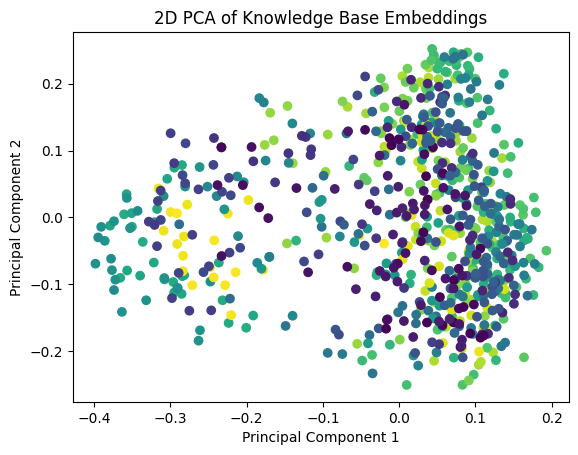

In [20]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Fetch embeddings and metadata
# result = collection.get(include=['embeddings', 'documents', 'metadatas'])
# vectors = np.array(result['embeddings'])
# doc_types = [m['doc_type'] for m in result['metadatas']]

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors   = np.array(result['embeddings'])
doc_types = [m.get('doc_type', 'Unknown') for m in result['metadatas']]
docs_text = result['documents']  # this is a list of strings


# 2. Map each doc_type to a numeric color index
# unique_types = sorted(set(doc_types))
# color_map = {t: i for i, t in enumerate(unique_types)}
# colors = [color_map[t] for t in doc_types]

unique_types = sorted(set(doc_types))
color_map = {t: idx for idx, t in enumerate(unique_types)}
colors = [color_map[t] for t in doc_types]

# 3. PCA → 2D
pca = PCA(n_components=2)
points_2d = pca.fit_transform(vectors)

# 4. Plot
plt.figure()
plt.scatter(points_2d[:, 0], points_2d[:, 1], c=colors)
plt.title("2D PCA of Knowledge Base Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [21]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
points_3d = tsne.fit_transform(vectors)

# 5. Plotly 3D scatter
fig = go.Figure(data=[go.Scatter3d(
    x=points_3d[:, 0],
    y=points_3d[:, 1],
    z=points_3d[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, docs_text)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D t-SNE of Chroma Embeddings',
    scene=dict(xaxis_title='Dim 1', yaxis_title='Dim 2', zaxis_title='Dim 3'),
    width=900, height=700,
    margin=dict(r=20,b=10,l=10,t=40)
)

fig.show()

# **Setting up the Langchain Library**

In [22]:
MODEL = "gpt-4o-mini"
from langchain_core.callbacks import StdOutCallbackHandler

llm = ChatOpenAI(temperature=0.7, model_name=MODEL,api_key=userdata.get('openai'))

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever()

# The call backs , is just to debug and tell what is sent to Langchain and what all chunks lang chain is using to answer the questions
# We can increase the number of chunks sent to Langchain to tell the answer we can get more accurate results.

#conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, callbacks=[StdOutCallbackHandler()])
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

<ipython-input-22-3010564535>:6: LangChainDeprecationWarning:

Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/



In [23]:
question = "tell me about apple scab leaf"
result = conversation_chain.invoke({"question": question})
print(result)

{'question': 'tell me about apple scab leaf', 'chat_history': [HumanMessage(content='tell me about apple scab leaf', additional_kwargs={}, response_metadata={}), AIMessage(content='Apple scab is a fungal disease caused by the fungus *Venturia inaequalis* that primarily affects the leaves of apple and crabapple trees. Here are the key points regarding apple scab symptoms on leaves:\n\n- **Initial Symptoms**: Circular, olive-green spots appear on the upper surface of the leaves, resembling pinheads. The spots are velvet-like with fringed edges.\n- **Progression**: As the disease progresses, these spots enlarge and may turn dark brown to black. The size can increase up to ½ inch in diameter.\n- **Leaf Distortion**: Infected leaves may become twisted or distorted. \n- **Defoliation**: Extensive infections can lead to yellowing of leaves and premature dropping by mid-summer. Severe cases may cause total defoliation, which can stress the trees and make them more susceptible to other diseases

# **GPT Api calling Tool Configuration**

In [26]:
def plant_disease_qa(question, chat_history):
    # the last user turn in chat_history is the raw user text:
    raw = chat_history[-1]["content"] if chat_history else question
    print("Plant disease QA tool is called")
    print(f"Raw user text was: {raw}")
    print(f"Canonical question passed: {question}")

    result = conversation_chain.invoke({"question": question})
    print(result)
    return result["answer"]

In [27]:
plant_disease_tool = {
    "name": "plant_disease_qa",
    "description": "Answer questions about plant diseases using the knowledge base.",
    "parameters": {
        "type": "object",
        "properties": {
            "question": {
                "type": "string",
                "description": "The user's question is about a plant disease, or it's cure"
            },
            "chat_history": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "role": {"type": "string", "enum": ["user", "assistant"]},
                        "content": {"type": "string"}
                    },
                    "required": ["role", "content"]
                },
                "description": "Prior conversation turns."
            }
        },
        "required": ["question", "chat_history"],
        "additionalProperties": False
    }
}


In [28]:
plant_disease_detect_tool = {
    "name": "detect_plant_disease",
    "description": "Detect diseases in an uploaded plant image and return the annotated image plus a list of detections.",
    "parameters": {
        "type": "object",
        "properties": {
            "image": {
                "type": "string",
                "description": "Base64-encoded image to analyze."
            },
            "confidence_threshold": {
                "type": "number",
                "description": "Confidence cutoff for showing a detection.",
                "default": 0.5
            }
        },
        "required": ["image"],
        "additionalProperties": False
    }
}


In [29]:
tools = [
    {"type": "function", "function": plant_disease_tool},
    {"type": "function", "function": plant_disease_detect_tool},
]


In [31]:
# Load your trained model
disease_model = YOLO("best.pt")

def process_image(image, confidence_threshold=0.5):
    """
    Runs inference on the BGR numpy `image`, draws bounding boxes for
    detections above `confidence_threshold`, and returns:
      - annotated image (with boxes & labels drawn)
      - list of unique detected class names
      - status message
    """
    # run inference
    print("Plant disease detector is called")
    results = disease_model(image)
    classNames = [
        'Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf',
        'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf',
        'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight',
        'Corn rust leaf', 'Peach leaf', 'Potato leaf',
        'Potato leaf early blight', 'Potato leaf late blight',
        'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf',
        'Strawberry leaf', 'Tomato Early blight leaf',
        'Tomato Septoria leaf spot', 'Tomato leaf',
        'Tomato leaf bacterial spot', 'Tomato leaf late blight',
        'Tomato leaf mosaic virus', 'Tomato leaf yellow virus',
        'Tomato mold leaf', 'Tomato two spotted spider mites leaf',
        'grape leaf', 'grape leaf black rot'
    ]

    # collect unique detections
    detected_names = set()

    # draw all boxes and fill the set
    for result in results:
        for box in result.boxes:
            conf = float(box.conf[0])
            if conf < confidence_threshold:
                continue

            cls_id = int(box.cls[0])
            name = classNames[cls_id]
            detected_names.add(name)

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                image,
                f"{name}: {conf:.2f}",
                (x1, max(0, y1 - 10)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (255, 255, 0),
                3
            )

    # return annotated image and results
    if not detected_names:
        return image, [], "No confident detections"
    return image, list(detected_names), "Detections complete"

In [32]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    name = tool_call.function.name
    args = json.loads(tool_call.function.arguments)

    if name == "plant_disease_qa":
        answer = plant_disease_qa(
            question=args["question"],
            chat_history=args.get("chat_history", [])
        )
        content = {"answer": answer}

    elif name == "detect_plant_disease":
        print("entered detection mode")
        # decode the image
        b64 = args["image"]
        threshold = args.get("confidence_threshold", 0.5)
        raw = base64.b64decode(b64)
        pil_img = Image.open(io.BytesIO(raw)).convert("RGB")
        cv_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

        ann, names, msg = process_image(cv_img, threshold)
        # re-encode annotated image
        _, buf = cv2.imencode(".jpg", ann)
        ann_b64 = base64.b64encode(buf).decode("utf-8")

        content = {
            "annotated_image": ann_b64,
            "detected_diseases": list(names),
            "message": msg
        }

    else:
        raise ValueError(f"Unknown tool {name}")

    return {
        "role": "tool",
        "content": json.dumps(content),
        "tool_call_id": tool_call.id
    }, None


# **Setting up the Gradio UI**


In [33]:
def pil_to_data_url(img: Image.Image) -> str:
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    b64 = base64.b64encode(buf.getvalue()).decode()
    return f"data:image/png;base64,{b64}"

MODEL = "gpt-4o-mini"
system_message = (
    "You are a helpful plant-disease assistant. "
    "If the user uploads an image, you may call detect_plant_disease. "
    "If the user asks a question, you may call plant_disease_qa"
    "If you dont get the answer with the tools , you should respond, I don't know"
)

def user_interact(user_text, user_image, ui_history, oa_history):
    # 1) Image upload → detect locally, then show annotated leaf + question
    if user_image is not None:
        # Run your detector
        cv_img = cv2.cvtColor(np.array(user_image), cv2.COLOR_RGB2BGR)
        ann_bgr, names, msg = process_image(cv_img, confidence_threshold=0.5)

        # Convert back to PIL
        ann_rgb = cv2.cvtColor(ann_bgr, cv2.COLOR_BGR2RGB)
        ann_pil = Image.fromarray(ann_rgb)

        # Build plain text summary
        if names:
            disease_list = ", ".join(names)
            summary = f"Detected disease(s): {disease_list}. {msg}"
        else:
            disease_list = None
            summary = f"No confident detections. {msg}"

        # UI: show image + follow-up question in Markdown
        img_url = pil_to_data_url(ann_pil)
        bot_md = (
            f"![annotated leaf]({img_url})\n\n"
            f"> The detected disease is **{disease_list or 'none'}**. "
            "What would you like to do next?"
        )
        # Append a placeholder for the user turn (so UI lines up)
        ui_history.append((None, None))
        # Append the bot markdown turn
        ui_history.append((bot_md, None))

        # API history: only record the TEXT summary + question
        oa_history.append({"role": "user", "content": "<leaf image upload>"})
        oa_history.append({
            "role": "assistant",
            "content": f"{summary} What would you like to do next?"
        })

        return "", None, ui_history, oa_history

    # 2) Otherwise, text → fall back to your RAG‐QA pipeline
    ui_history.append((user_text, None))
    oa_history.append({"role": "user", "content": user_text})

    resp = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "system", "content": system_message}] + oa_history,
        tools=tools
    )

    if resp.choices[0].finish_reason == "tool_calls":
        tool_msg = resp.choices[0].message
        tool_resp, _ = handle_tool_call(tool_msg)
        payload = json.loads(tool_resp["content"])
        reply = payload.get("answer")
        oa_history.append({"role": "assistant", "content": tool_resp["content"]})
    else:
        reply = resp.choices[0].message.content
        oa_history.append({"role": "assistant", "content": reply})

    ui_history[-1] = (user_text, reply)
    return "", None, ui_history, oa_history

In [36]:
with gr.Blocks() as demo:
    gr.Markdown("## 🌿 Plant‐Disease Chat & Detector")
    chatbot   = gr.Chatbot(label="Conversation")
    oa_history = gr.State([])

    with gr.Row():
        txt = gr.Textbox(placeholder="Ask a question…", show_label=False)
        img = gr.Image(type="pil", label="…or upload a leaf photo")

    send = gr.Button("Send")
    send.click(
        fn=user_interact,
        inputs=[txt, img, chatbot, oa_history],
        outputs=[txt, img, chatbot, oa_history],
    )

demo.launch(debug=True)

<ipython-input-36-1009798760>:3: UserWarning:

You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.



It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://456758b8c3aa13fc21.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Plant disease QA tool is called
Raw user text was: Can you tell me about apple scab leaf ?
Canonical question passed: What is apple scab and how does it affect apple leaves?
{'question': 'What is apple scab and how does it affect apple leaves?', 'chat_history': [HumanMessage(content='tell me about apple scab leaf', additional_kwargs={}, response_metadata={}), AIMessage(content='Apple scab is a fungal disease caused by the fungus *Venturia inaequalis* that primarily affects the leaves of apple and crabapple trees. Here are the key points regarding apple scab symptoms on leaves:\n\n- **Initial Symptoms**: Circular, olive-green spots appear on the upper surface of the leaves, resembling pinheads. The spots are velvet-like with fringed edges.\n- **Progression**: As the disease progresses, these spots enlarge and may turn dark brown to black. The size can increase up to ½ inch in diameter.\n- **Leaf Distortion**: Infected leaves may become twisted or distorted. \n- **Defoliation**: Extensiv